In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import typing as tp

import arch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from ovm.historical.data_io import (
    PriceHistoryColumnNames as PHCN, 
    compute_number_of_days_in_price_history, 
    compute_log_returns_from_price_history, 
    save_price_histories, 
    load_price_history
)

from ovm.paths import HISTORICAL_DATA_DIRECTORY

from ovm.utils import TimeResolution

In [3]:
from recombinator import (
    stationary_bootstrap, 
    tapered_block_bootstrap
)

from recombinator.optimal_block_length import optimal_block_length

In [4]:
%matplotlib inline

In [5]:
# def adf_test(timeseries):
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#        dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

In [6]:
time_resolution = TimeResolution.FIFTEEN_SECONDS
# directory_path = time_resolution.value
directory_path = os.path.join(HISTORICAL_DATA_DIRECTORY, time_resolution.value)

In [7]:
directory_path

'/Volumes/GIT/PycharmProjects/overlay-monetary/data/historical/15s'

In [8]:
price_history_file_name = 'ETH-USD'

In [9]:
price_history = \
    load_price_history(filename=price_history_file_name, 
                       series_name=price_history_file_name, 
                       directory_path=directory_path, 
                       period_length_in_seconds=time_resolution.in_seconds)
df = price_history.price_history_df

In [10]:
# df = pd.read_parquet(path=os.path.join(directory_path, price_history_file_name))

In [11]:
df.tail(15)

,open,high,low,close,volume
start_time,,,,,
1605818895000,474.79,474.79,474.51,474.54,0.00000
1605818910000,474.54,474.78,474.54,474.78,0.00000
1605818925000,474.78,474.78,474.78,474.78,0.00000
1605818940000,474.78,474.78,474.62,474.67,1043.25872
1605818955000,474.67,474.71,474.64,474.64,0.00000
1605818970000,474.64,474.64,474.60,474.63,0.00000
1605818985000,474.63,474.63,474.40,474.42,498.17250
1605819000000,474.42,474.69,474.40,474.69,2378.65030
1605819015000,474.69,474.70,474.69,474.69,0.00000


In [12]:
# def compute_log_returns_from_price_history(price_history_df: pd.DataFrame, 
#                                            period_length_in_seconds: float, 
#                                            name: tp.Optional[str] = None) -> pd.Series:
#     log_returns = np.log(price_history_df[PHCN.CLOSE]).diff().dropna() * np.sqrt(365 * 24 * 60 * 60 / period_length_in_seconds)
#     if name is not None:
#         log_returns.name = name
#     return log_returns

In [13]:
log_return_series = \
    compute_log_returns_from_price_history(df, period_length_in_seconds=15, name='eth/usd return')

In [14]:
# log_return_series = np.log(df[PHCN.CLOSE]).diff().dropna() * np.sqrt(365 * 24 * 60 * 4)

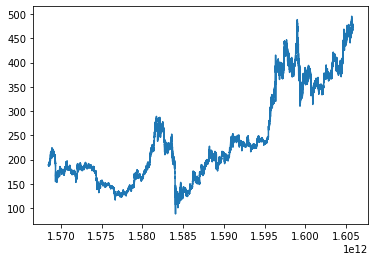

In [15]:
plt.plot(df[PHCN.CLOSE]);

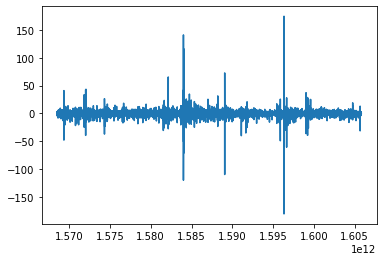

In [16]:
plt.plot(log_return_series);

## GJR Garch with Normal Distribution

In [17]:
# a standard GJR-GARCH(1,1) model
gjr_garch = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=1, 
                        q=1)
gjr_garch_fitted = gjr_garch.fit()
gjr_garch_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 293565973163.7814
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2111234.1006934894
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2111234.0972447153
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:           -2.11123e+06
Distribution:                  Normal   AIC:                       4.22248e+06
Method:            Maximum Likelihood   BIC:                       4.22254e+06
                                        No. Observations:              2485980
Date:                Sat, Jan 16 2021   Df Residuals:                  2485975
Time:                        10:09:58   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.1379e-03  4.482e-03     -1.816  6.942e-02 [-1.692e-02,6.466e-04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.080e-02      1.603      0.109 [-3.854e-03,3.847e-02]
alpha[1]       0.1000  2.152e-02      4.647  3.370e-06    [5.782e-02,  0.142]
gamma[1]       0.1000  5.741e-02      1.742  8.151e-02   [-1.251e-02,  0.213]
beta[1]        0.8300  5.927e-02     14.004  1.483e-44      [  0.714,  0.946]
=============================================================================

Covariance estimator: robust
"""

## With Normal Distribution

In [18]:
# a standard GARCH(1,1) model
garch = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=1)
garch_fitted = garch.fit()
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 632030138171419.9
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2117900.1877745283
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2117900.199066052
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.11790e+06
Distribution:                  Normal   AIC:                       4.23581e+06
Method:            Maximum Likelihood   BIC:                       4.23586e+06
                                        No. Observations:              2485980
Date:                Sat, Jan 16 2021   Df Residuals:                  2485976
Time:                        10:10:11   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.8281e-03  3.901e-04      9.813  9.891e-23 [3.064e-03,4.593e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  5.621e-03      3.079  2.079e-03 [6.289e-03,2.832e-02]
alpha[1]       0.2000  3.206e-02      6.238  4.439e-10     [  0.137,  0.263]
beta[1]        0.7800  4.069e-02     19.171  6.456e-82     [  0.700,  0.860]
============================================================================

Covariance estimator: robust
"""

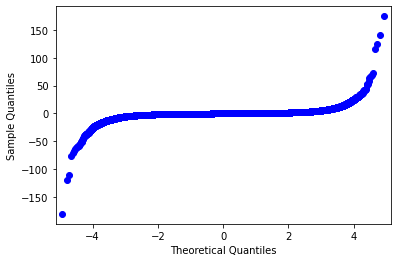

In [19]:
# plot residuals
sm.qqplot(garch_fitted.resid);

In [20]:
# a standard GARCH(1,2) model
garch_12 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=2)
garch_12_fitted = garch_12.fit()
garch_12_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 146650444974899.1
Iteration:      2,   Func. Count:     21,   Neg. LLF: 181049011.782299
Iteration:      3,   Func. Count:     34,   Neg. LLF: 17759232.993646353
Iteration:      4,   Func. Count:     45,   Neg. LLF: 15431689075823.87
Iteration:      5,   Func. Count:     58,   Neg. LLF: 2090468.999129576
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2090469.0010463565
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.09047e+06
Distribution:                  Normal   AIC:                       4.18095e+06
Method:            Maximum Likelihood   BIC:                       4.18101e+06
                                        No. Observations:              2485980
Date:                Sat, Jan 16 2021   Df Residuals:                  2485975
Time:                        10:10:27   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.2293e-03  3.510e-04      9.199  3.613e-20 [2.541e-03,3.917e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  9.055e-03      1.911  5.595e-02 [-4.397e-04,3.505e-02]
alpha[1]       0.2000  4.458e-02      4.487  7.215e-06      [  0.113,  0.287]
beta[1]        0.3900  8.396e-02      4.646  3.390e-06      [  0.225,  0.555]
beta[2]        0.3900  2.893e-02     13.481  2.021e-41      [  0.333,  0.447]
=============================================================================

Covariance estimator: robust
"""

In [21]:
# a standard GARCH(1,3) model
garch_13 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=3)
garch_13_fitted = garch_13.fit()
garch_13_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 8.29331050786012e+21
Iteration:      2,   Func. Count:     22,   Neg. LLF: 2082687.04680927
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2082687.044359638
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.08269e+06
Distribution:                  Normal   AIC:                       4.16539e+06
Method:            Maximum Likelihood   BIC:                       4.16546e+06
                                        No. Observations:              2485980
Date:                Sat, Jan 16 2021   Df Residuals:                  2485974
Time:                        10:10:39   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.7726e-03  3.333e-04      8.319  8.878e-17 [2.119e-03,3.426e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0173  1.822e-02      0.950      0.342 [-1.840e-02,5.302e-02]
alpha[1]       0.2000  9.292e-02      2.152  3.136e-02    [1.789e-02,  0.382]
beta[1]        0.2600  8.942e-02      2.908  3.641e-03    [8.475e-02,  0.435]
beta[2]        0.2600  8.104e-02      3.208  1.335e-03      [  0.101,  0.419]
beta[3]        0.2600  4.771e-02      5.449  5.053e-08      [  0.166,  0.354]
=============================================================================

Covariance estimator: robust
"""

In [22]:
# a standard GARCH(2,1) model
garch_21 = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=2, 
                        o=0, 
                        q=1)
garch_21_fitted = garch_21.fit()
garch_21_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2.03707115932229e+22
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5205813410.901851
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4733643.350093263
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2126523.4892509305
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2126523.497946362
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:         eth/usd return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:           -2.12652e+06
Distribution:                  Normal   AIC:                       4.25306e+06
Method:            Maximum Likelihood   BIC:                       4.25312e+06
                                        No. Observations:              2485980
Date:                Sat, Jan 16 2021   Df Residuals:                  2485975
Time:                        10:10:56   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.0383e-03  4.714e-04      8.567  1.063e-17 [3.114e-03,4.962e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0178  8.208e-03      2.168  3.016e-02 [1.707e-03,3.388e-02]
alpha[1]       0.1000  5.396e-03     18.530  1.178e-76   [8.942e-02,  0.111]
alpha[2]       0.1000  4.630e-02      2.159  3.082e-02   [9.236e-03,  0.191]
beta[1]        0.7799  6.111e-02     12.763  2.647e-37     [  0.660,  0.900]
============================================================================

Covariance estimator: robust
"""

## With T Distribution

In [23]:
# a GARCH(1,1) model with Student t distributed errors 
garch_11_t = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='StudentsT'
                   )
garch_11_t_fitted = garch_11_t.fit()
garch_11_t_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 79129805.79060787
Iteration:      2,   Func. Count:     22,   Neg. LLF: 80888917.61945553
Iteration:      3,   Func. Count:     33,   Neg. LLF: 119768896.6174169
Iteration:      4,   Func. Count:     48,   Neg. LLF: 90686505.20289567
Iteration:      5,   Func. Count:     61,   Neg. LLF: 83119316.84795986
Iteration:      6,   Func. Count:     73,   Neg. LLF: 115634579.87095194
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1735173.053234503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735173.0525404052
            Iterations: 11
            Function evaluations: 86
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.73517e+06
Distribution:      Standardized Student's t   AIC:                       3.47036e+06
Method:                  Maximum Likelihood   BIC:                       3.47042e+06
                                              No. Observations:              2485980
Date:                      Sat, Jan 16 2021   Df Residuals:                  2485975
Time:                              10:11:17   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.9918e-06  1.559e-04  4.484e-02      0.964 [-2.986e-04,3.126e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.090e-04    158.707      0.000 [1.709e-02,1.752e-02]
alpha[1]       0.2000  9.372e-04    213.394      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.571e-04    909.991      0.000     [  0.778,  0.782]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0216  6.907e-03    582.222      0.000 [  4.008,  4.035]
========================================================================

Covariance estimator: robust
"""

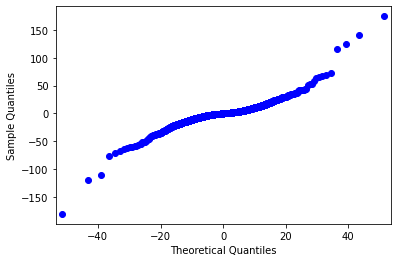

In [24]:
# plot residuals
sm.qqplot(garch_11_t_fitted.resid, dist=sp.stats.t(garch_11_t_fitted.params['nu']));

In [25]:
sim_mod = arch.arch_model(None, vol='garch', p=1, o=0, q=1, dist="StudentsT")

sim_data = sim_mod.simulate(garch_11_t_fitted.params, 1000)
sim_data.head()

,data,volatility,errors
0,-0.015451,0.586223,-0.015458
1,1.029117,0.534231,1.029110
2,-1.091048,0.672107,-1.091055
3,-0.142989,0.779567,-0.142996
4,0.538763,0.703857,0.538756


In [26]:
# a GARCH(1,2) model with Student t distributed errors 
garch_12_t = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=2, 
                    dist='StudentsT')
garch_12_t_fitted = garch_12_t.fit()
garch_12_t_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 664937301.9294909
Iteration:      2,   Func. Count:     23,   Neg. LLF: 86890503.37439324
Iteration:      3,   Func. Count:     36,   Neg. LLF: 113234228.24052942
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1735880.4918644843
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735880.4911508432
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.73588e+06
Distribution:      Standardized Student's t   AIC:                       3.47177e+06
Method:                  Maximum Likelihood   BIC:                       3.47185e+06
                                              No. Observations:              2485980
Date:                      Sat, Jan 16 2021   Df Residuals:                  2485974
Time:                              10:11:43   Df Model:                            6
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.0648e-05  1.557e-04     -0.454      0.650 [-3.759e-04,2.346e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.005e-04    172.288      0.000 [1.711e-02,1.750e-02]
alpha[1]       0.2000  9.619e-04    207.910      0.000     [  0.198,  0.202]
beta[1]        0.3900  5.287e-03     73.760      0.000     [  0.380,  0.400]
beta[2]        0.3900  5.342e-03     73.003      0.000     [  0.380,  0.400]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0227  6.156e-03    653.491      0.000 [  4.011,  4.035]
========================================================================

Covariance estimator: robust
"""

In [27]:
# a GARCH(1,3) model with Student t distributed errors 
garch_13_t = arch.arch_model(log_return_series, 
                        vol='garch', 
                        p=1, 
                        o=0, 
                        q=3, 
                        dist='StudentsT')
garch_13_t_fitted = garch_13_t.fit()
garch_13_t_fitted.summary()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 557090541.2769711
Iteration:      2,   Func. Count:     24,   Neg. LLF: 1739107.9985534672
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1739107.997825212
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:               eth/usd return   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:           -1.73911e+06
Distribution:      Standardized Student's t   AIC:                       3.47823e+06
Method:                  Maximum Likelihood   BIC:                       3.47832e+06
                                              No. Observations:              2485980
Date:                      Sat, Jan 16 2021   Df Residuals:                  2485973
Time:                              10:12:02   Df Model:                            7
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.0332e-04  1.558e-04      0.663      0.507 [-2.020e-04,4.086e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  9.822e-05    176.200      0.000 [1.711e-02,1.750e-02]
alpha[1]       0.2000  1.039e-03    192.536      0.000     [  0.198,  0.202]
beta[1]        0.2600  6.498e-03     40.014      0.000     [  0.247,  0.273]
beta[2]        0.2600  7.523e-03     34.561 9.605e-262     [  0.245,  0.275]
beta[3]        0.2600  6.838e-03     38.025      0.000     [  0.247,  0.273]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.0216  5.852e-03    687.264      0.000 [  4.010,  4.033]
========================================================================

Covariance estimator: robust
"""

## With Skewed T Distribution

In [28]:
# a GARCH(1,1) model with Student t distributed errors 
garch_11_skewt = \
    arch.arch_model(log_return_series, 
                    vol='garch', 
                    p=1, 
                    o=0, 
                    q=1, 
                    dist='skewt'
                   )
garch_11_skewt_fitted = garch_11_skewt.fit()
garch_11_skewt_fitted.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6645890898.9108515
Iteration:      2,   Func. Count:     23,   Neg. LLF: 79960789.9672098
Iteration:      3,   Func. Count:     35,   Neg. LLF: 228810676.6304806
Iteration:      4,   Func. Count:     51,   Neg. LLF: 199595838.17183885
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1735176.5985001575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1735176.5986928972
            Iterations: 9
            Function evaluations: 64
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                    eth/usd return   R-squared:                      -0.000
Mean Model:                        Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                 GARCH   Log-Likelihood:           -1.73518e+06
Distribution:      Standardized Skew Student's t   AIC:                       3.47037e+06
Method:                       Maximum Likelihood   BIC:                       3.47044e+06
                                                   No. Observations:              2485980
Date:                           Sat, Jan 16 2021   Df Residuals:                  2485974
Time:                                   10:12:29   Df Model:                            6
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1780e-04  2.719e-04      0.433      0.665 [-4.150e-04,6.507e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0173  1.090e-04    158.715      0.000 [1.709e-02,1.752e-02]
alpha[1]       0.2000  9.372e-04    213.392      0.000     [  0.198,  0.202]
beta[1]        0.7800  8.571e-04    910.037      0.000     [  0.778,  0.782]
                                 Distribution                                
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
nu             4.0216  6.907e-03    582.272      0.000      [  4.008,  4.035]
lambda     1.0380e-05  6.116e-04  1.697e-02      0.986 [-1.188e-03,1.209e-03]
=============================================================================

Covariance estimator: robust
"""

In [29]:
bootstrap_log_returns = \
    stationary_bootstrap(x=log_return_series.values, 
                         block_length=24 * 60 * 60 / 15, 
                         replications=10)

In [30]:
bootstrap_log_returns.shape

(10, 2485980)

In [31]:
np.unique(np.diff(df.index.values))

array([  15000,   30000,   45000,   60000,   75000,   90000,  105000,
        120000,  135000,  150000,  165000,  180000,  195000,  210000,
        240000,  285000,  315000,  330000,  375000,  390000,  420000,
        540000,  555000,  630000,  765000,  795000,  870000, 1050000,
       1230000, 1245000, 4335000])

In [32]:
(np.diff(df.index.values) != 15000).sum()

759

(array([2.485969e+06, 6.000000e+00, 4.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  15000.,  447000.,  879000., 1311000., 1743000., 2175000.,
        2607000., 3039000., 3471000., 3903000., 4335000.]),
 <BarContainer object of 10 artists>)

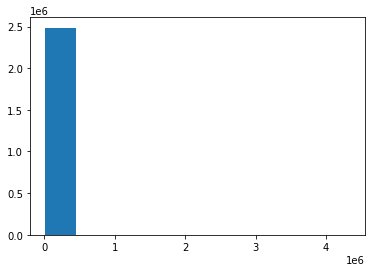

In [33]:
plt.hist(np.diff(df.index.values))

In [34]:
len(df)

2485981